In [3]:
import os
import sys
import time
import numpy as np
import copy
import pandas as pd
import pickle
import scipy
import scipy.special
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import collections
from collections import OrderedDict
import glob
import progressbar
import qutip

import sklearn
import sklearn.decomposition
import skimage
import skimage.transform

import plotly
import plotly.offline
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

if '..' not in sys.path:
    sys.path.append('..')
import src
import src.vector_vortex_beams as VVB
import src.utils as utils
from src.utils import abs2, borderless_imshow_save, imshow_intensities
import src.data_files_utils as data_files_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PCA on OAM states

Generate datasets of OAM images and apply PCA to it.

We start by generating a simulated dataset of OAMs and applying PCA to it

In [30]:
# generate the tuples (p, (m1, m2)), with p fixed and (m1, m2) changing
tuples_to_generate = []
p_list = [0, 1, 2]
m_list = [0, 1, 2, 3, 4, 5]
for p in p_list:
    for m in m_list:
        tuples_to_generate.append([(p, m)])
tuples_to_generate.append([(1, 1), (1, 2)])
tuples_to_generate.append([(1, 1), (1, 3)])
tuples_to_generate.append([(1, 1), (1, 4)])
# actually generate, reduce, and classify the data
OAM_dataset = VVB.OAMDataset()
OAM_dataset.generate_data(parameters=tuples_to_generate, num_samples=20, noise_level=0.1,
                          polarization_state='sequential phases', monitor='progressbar')
OAM_dataset.apply_PCA(n_components=20, svd_solver='randomized', whiten=True)
OAM_dataset.fit_SVM(gamma='auto')

100% (21 of 21) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


Plot singular values:

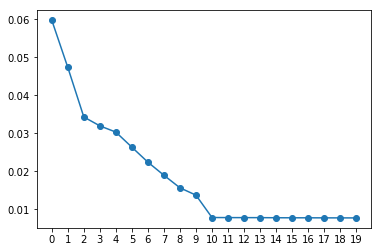

In [69]:
plt.plot(OAM_dataset.pca.singular_values_, 'o-'); plt.xticks(np.arange(20));

Show principal components as images. Note how only the first 9 contain meaningful patterns, consistently with there only being 9 non-zero singular values.

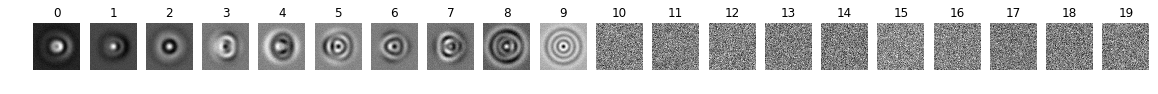

In [104]:
fig, axs = plt.subplots(ncols=20, figsize=(20, 4))
for idx, ax in enumerate(axs):
    ax.imshow(OAM_dataset.pca.components_[idx].reshape((300, 300)), cmap='gray');
    ax.axis('off'); ax.set_title(idx)

# Apply PCA + SVC to classify VVBs

In [71]:
# generate the tuples (p, (m1, m2)), with p fixed and (m1, m2) changing
p = 1
tuples_to_generate = []
m_list = [-5, -3, -1, 1, 3, 5]
for (m, n) in list(itertools.combinations_with_replacement(m_list, r=2)):
    if (p, (-m, -n)) not in tuples_to_generate:
        tuples_to_generate.append((p, (m, n)))

# actually generate, reduce, and classify the data
dataset = VVB.VVBDataset()
dataset.generate_data(parameters=tuples_to_generate, num_samples=100, noise_level=0.1, polarization_state='sequential phases', monitor=True)
dataset.apply_PCA(n_components=20, svd_solver='randomized', whiten=True)
dataset.fit_SVM(gamma='scale')

100%|██████████| 18/18 [01:21<00:00,  4.50s/it]


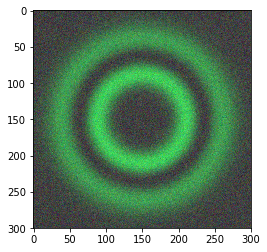

In [106]:
plt.imshow(utils.rescale_array_values(
    np.transpose(dataset.dataset[3].reshape((3, 300, 300)), [1, 2, 0]), [0, 255]).astype(np.uint8))

Save the generated images as png files:

In [107]:
# for label_idx, label_name in enumerate(dataset.labels_names):
#     path = '../data/noise0.1/{}'.format(label_name)
#     path = path.replace(' ', '')
#     os.makedirs(path, exist_ok=True)
#     data_per_label = dataset.dataset[np.array(dataset.labels) == label_idx]
#     for image_idx, image_data in enumerate(data_per_label):
#         image_data = image_data.reshape((3, 300, 300))
#         image_data = np.transpose(image_data, [1, 2, 0])
#         image_data = utils.rescale_array_values(image_data, [0, 255]).astype(np.uint8)
#         filename = os.path.join(path, '({:03}).png'.format(image_idx))
#         utils.borderless_imshow_save(image_data, outputname=filename)

In [9]:
# import pickle
# import copy
# dataset_to_save = copy.deepcopy(dataset)
# del dataset_to_save.dataset
# with open('trained_dataset_pca+svc_p1_noice0.01.pickle', 'wb') as fp:
#     pickle.dump(dataset_to_save, fp)

## PCA on simulated data

Generate dataset of simulated VVB images and apply PCA to it.

Uncomment the following to generate and save to file a dataset

In [ ]:
# tuples_to_generate = [(0, (1, 2)), (0, (3, 4))]
# data_files_utils.generate_VVB_superpositions_dataset(
#     pars_to_generate=tuples_to_generate, num_samples_per_class=100, noise_level=0,
#     data_dir=os.path.join('..', 'data', 'simulated_p0_m+1+2_and_m+3+4'), output_shape=(100, 100),
#     polarization_state='uniform random')

For images generated as superpositions of the form $c_1\lvert1\rangle+c_2\lvert2\rangle$ and $c_1'\lvert1\rangle+c_4'\lvert4\rangle$, the underlying covered space had dimension $6$, and this is reflected in the singular values:

In [81]:
data_dir = os.path.join('..', 'data', 'simulated_m+1+2_and_m+1+4')
sim_pca_twoclasses = data_files_utils.train_pca_on_files_in_dir(
    data_dir, n_components=10, output_shape=(100, 100), monitor='progressbar')
sim_fulldataset_twoclasses = data_files_utils.ImagesDatasetToReduce(
    data_dir=data_dir,
    pca=sim_pca_twoclasses)

100% (2 of 2) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


Computing reduced representation of the images


Plot singular values:

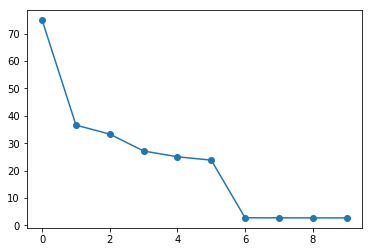

In [79]:
plt.plot(sim_pca_twoclasses.singular_values_, 'o-');

Show principal components as images:

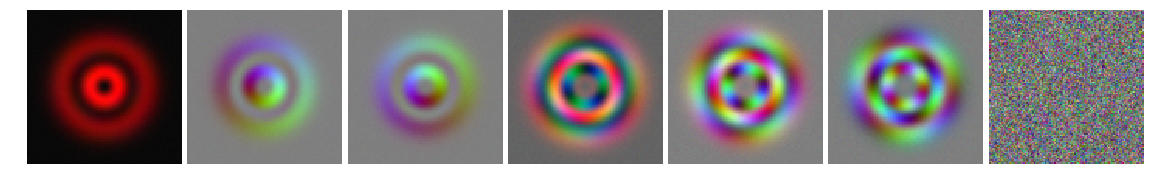

In [529]:
components_to_use = sim_pca_twoclasses.components_[:7]
fig, axs = plt.subplots(ncols=components_to_use.shape[0], figsize=(20, 10))
for ax, component in zip(axs, components_to_use):
    ax.imshow(utils.rescale_array_values(
        component.reshape((100, 100, 3)), [0, 1]
    ));
    ax.axis('off')
plt.subplots_adjust(wspace=.04, hspace=0)

In [530]:
# fig.savefig('./simulated_m+1+2_and_m+1+4_components.png', bbox_inches='tight')

Same with superpositions of the form $c_1\lvert1\rangle+c_2\lvert2\rangle$ and $c_3'\lvert3\rangle+c_4'\lvert4\rangle$. The underlying covered space had dimension $7$, and this is reflected in the singular values:

100% (2 of 2) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


Computing reduced representation of the images


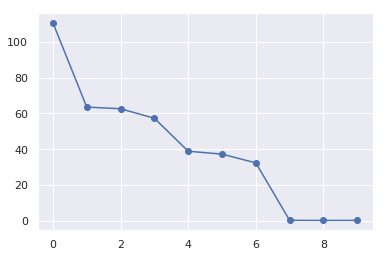

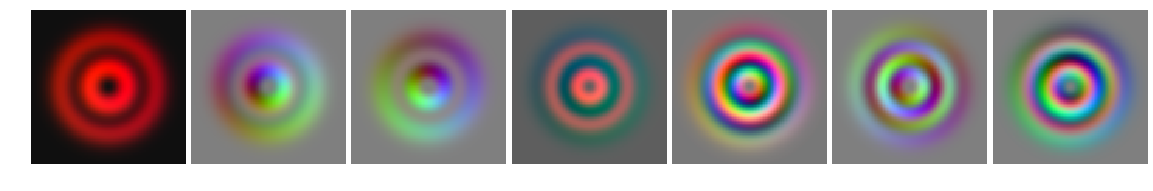

In [431]:
data_dir = os.path.join('..', 'data', 'simulated_m+1+2_and_m+3+4')
sim_pca_twoclasses = data_files_utils.train_pca_on_files_in_dir(
    data_dir, n_components=10, output_shape=(100, 100), monitor='progressbar')
sim_fulldataset_twoclasses = data_files_utils.ImagesDatasetToReduce(
    data_dir=data_dir,
    pca=sim_pca_twoclasses
)

plt.plot(sim_pca_twoclasses.singular_values_, 'o-')

components_to_use = sim_pca_twoclasses.components_[:7]
fig, axs = plt.subplots(ncols=components_to_use.shape[0], figsize=(20, 4))
for ax, component in zip(axs, components_to_use):
    ax.imshow(utils.rescale_array_values(
        component.reshape((100, 100, 3)), [0, 1]
    ));
    ax.axis('off')
plt.subplots_adjust(wspace=.04, hspace=0)
# fig.savefig('./simulated_m+1+2_and_m+3+4_components.png', bbox_inches='tight')

PCA on the dataset $\{c_1\lvert \uparrow, 1\rangle+c_2\lvert\downarrow, 2\rangle\}_{c_1,c_2}\cup \{c_1\lvert \uparrow, 2\rangle+c_2\lvert\downarrow, 1\rangle\}_{c_1,c_2}$ gives ***six*** dimensions

In [533]:
# tuples_to_generate = [(0, (1, 2)), (0, (2, 1))]
# data_files_utils.generate_VVB_superpositions_dataset(
#     pars_to_generate=tuples_to_generate, num_samples_per_class=100, noise_level=0,
#     data_dir=os.path.join('..', 'data', 'simulated_p0_m+1+2_and_m+2+1'), output_shape=(100, 100),
#     X=X, Y=Y, w0=reference_w0, polarization_state='uniform random')

100% (2 of 2) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


Computing reduced representation of the images


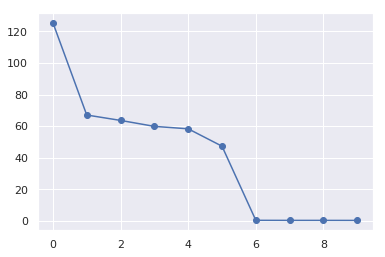

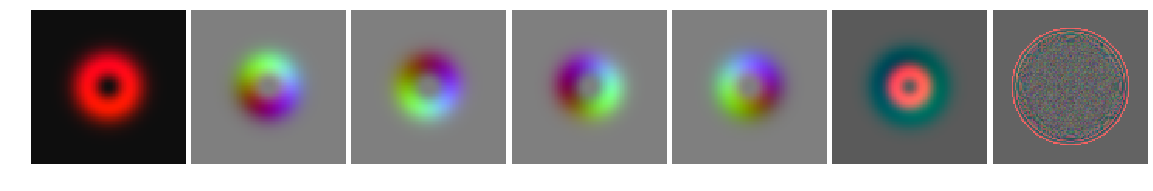

In [430]:
data_dir = os.path.join('..', 'data', 'simulated_p0_m+1+2_and_m+2+1')
sim_pca_twoclasses = data_files_utils.train_pca_on_files_in_dir(
    data_dir, n_components=10, output_shape=(100, 100), monitor='progressbar')
sim_fulldataset_twoclasses = data_files_utils.ImagesDatasetToReduce(
    data_dir=data_dir,
    pca=sim_pca_twoclasses)

plt.plot(sim_pca_twoclasses.singular_values_, 'o-')

components_to_use = sim_pca_twoclasses.components_[:7]
fig, axs = plt.subplots(ncols=components_to_use.shape[0], figsize=(20, 4))
for ax, component in zip(axs, components_to_use):
    ax.imshow(utils.rescale_array_values(
        component.reshape((100, 100, 3)), [0, 1]
    ));
    ax.axis('off')
plt.subplots_adjust(wspace=.04, hspace=0)
# fig.savefig('./simulated_m+1+2_and_m+2+1_components.png', bbox_inches='tight')

Finally, PCA on superpositions of the form $c_1\lvert\uparrow,m_1\rangle+c_2\lvert\downarrow,m_2\rangle$, for any $m_1,m_2$ (including $m_1=m_2$), recovers the hidden three-dimensional Bloch sphere in the image data:

In [542]:
tuples_to_generate = [(0, (1, 2))]
data_files_utils.generate_VVB_superpositions_dataset(
    pars_to_generate=tuples_to_generate, num_samples_per_class=1000, noise_level=0.1,
    data_dir=os.path.join('..', 'data', 'simulated_p0_m+1+2'), output_shape=(100, 100),
    X=X, Y=Y, w0=reference_w0, polarization_state='uniform random')

100% (1 of 1) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14
100% (1 of 1) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


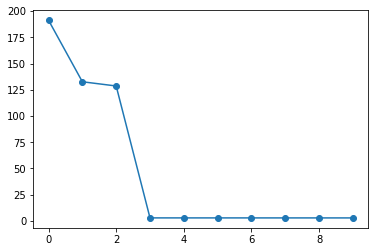

In [543]:
data_dir = os.path.join('..', 'data', 'simulated_p0_m+1+2')
sim_pca_twoclasses = data_files_utils.train_pca_on_files_in_dir(data_dir, n_components=10, output_shape=(100, 100),
                                                                monitor='progressbar')
sim_fulldataset_twoclasses = data_files_utils.ImagesDatasetToReduce(
    data_dir=data_dir,
    pca=sim_pca_twoclasses
)

plt.plot(sim_pca_twoclasses.singular_values_, 'o-')

Visualise what happens when we project the data on its first three principal components

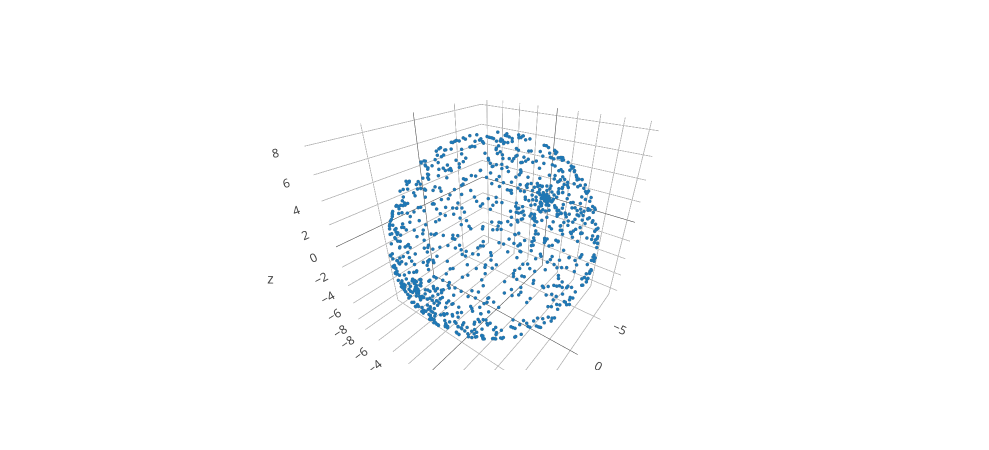

In [544]:
x, y, z = sim_fulldataset_twoclasses.merged_data[:, :3].T
plotly.offline.iplot([go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2))])

# Generate noisy images and recover the resulting Bloch sphere

Generate noisy images and recover the resultant Bloch sphere for states of the form $c_0\lvert\uparrow,m=1\rangle+c_1\lvert \downarrow,m=2\rangle$, fixing $p=1$.

In [37]:
tuples_to_generate = [(1, (1, 2))]
data_files_utils.generate_VVB_superpositions_dataset(
    pars_to_generate=tuples_to_generate, num_samples_per_class=100, noise_level=0.1,
    data_dir=os.path.join('..', 'data', 'single_qubit_uniform_polarization'), output_shape=(100, 100),
    X=X, Y=Y, w0=reference_w0, polarization_state='uniform random')

The linear PCA here clearly shows that the data is effectively three-dimensional, and returns the three directions along which the original Bloch sphere has been mapped:

[55.12716449 40.25462401 35.54091235  2.72520188  2.71940781]


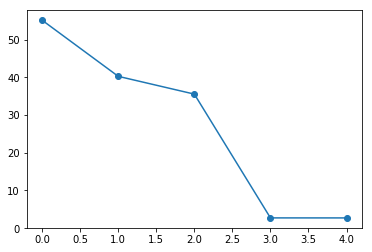

In [63]:
data_dir = os.path.join('..', 'data', 'single_qubit_uniform_polarization')
pca = data_files_utils.train_pca_on_files_in_dir(data_dir, n_components=5, output_shape=(100, 100))
print(pca.singular_values_)
plt.plot(pca.singular_values_, 'o-');

Display the first five principal component for the same data as above. Clearly, only the first three directions carry meaningful information, while the rest is picking up the noise.

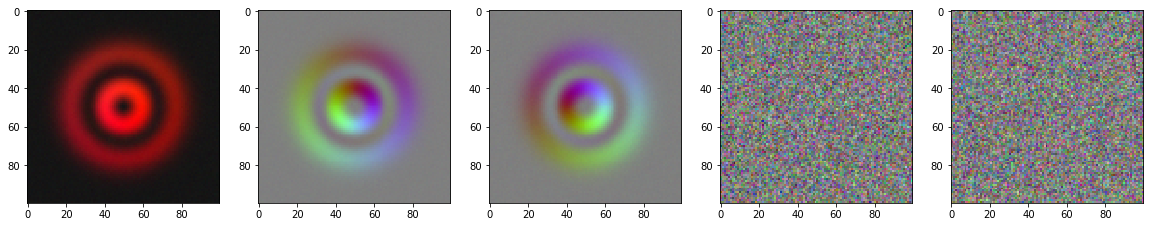

In [66]:
data_dir = os.path.join('..', 'data', 'single_qubit_uniform_polarization')
pca = data_files_utils.train_pca_on_files_in_dir(data_dir, n_components=5, output_shape=(100, 100))
fig, axs = plt.subplots(ncols=5, figsize=(20, 20))
for idx, component in enumerate(pca.components_):
    img = component.reshape((100, 100, 3))
    img = utils.rescale_array_values(img, [0, 1])
    axs[idx].imshow(img)

Same as above but downsampling to $50\times 50$ pixel images. There are no significant changes

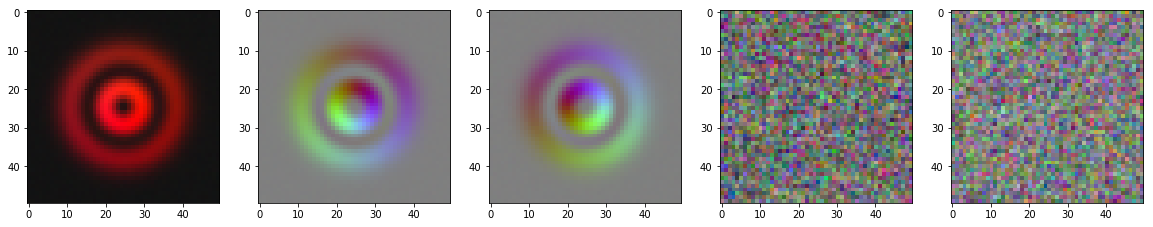

In [67]:
data_dir = os.path.join('..', 'data', 'single_qubit_uniform_polarization')
pca = data_files_utils.train_pca_on_files_in_dir(data_dir, n_components=5, output_shape=(50, 50))
fig, axs = plt.subplots(ncols=5, figsize=(20, 20))
for idx, component in enumerate(pca.components_):
    img = component.reshape((50, 50, 3))
    img = utils.rescale_array_values(img, [0, 1])
    axs[idx].imshow(img)

Show data in the reduced three dimensions:

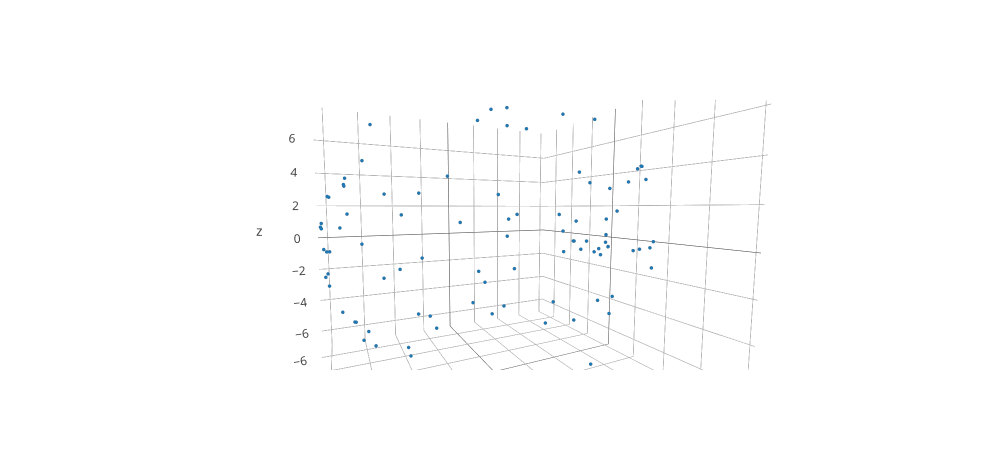

In [69]:
data_dir = os.path.join('..', 'data', 'single_qubit_uniform_polarization')
pca = data_files_utils.train_pca_on_files_in_dir(data_dir, n_components=3, output_shape=(100, 100))
reduced_images = data_files_utils.load_and_reduce_images_in_dir(data_dir=data_dir, reducer=pca, output_shape=(100, 100))

traces = [go.Scatter3d(
    x=reduced_images[:, 0], y=reduced_images[:, 1], z=reduced_images[:, 2],
    mode='markers', marker=dict(size=2)
)]
plotly.offline.iplot(traces)

# Load and classify experimental data on Bloch sphere

## Check accuracy of SVC on reduced space, using half of the given images

Use the following to split the dataset used above into two subsets. The new `train` set of images is built by randomly sampling half of the original images. The `test` set is the rest of the images (*don't run if you don't know what you are doing*).
Note that the rest of this section will assume the existence of a directory named `26classes_split`, which is not included in the GitHub repository (to train to contain its size). This folder can nevertheless be generated with the following code.

In [ ]:
# data_dir = os.path.join('..', 'data', 'experimental', '26classes')
# out_data_dir = os.path.join('..', 'data', 'experimental', '26classes_split')
# np.random.seed(0)
# data_files_utils.ImageDataFolder(data_dir).split_into_train_and_test_dirs(new_root_path=out_data_dir, train_ratio=0.5)

Now load all the images in the `train` directory, reduce them to $50\times 50$ pixels, and train a PCA reducer on the resulting images. Save the result to file for future ease of use.

In [4]:
def _():
    base_path = os.path.join(os.pardir, 'data', 'experimental', '26classes_split')
    data_dir = os.path.join(base_path, 'train')
    saved_file_path = os.path.join(base_path, 'trained_ipca_exp26classes_50x50pixels_trainset.pickle')
    # exp_pca_50pixels_train = data_files_utils.train_pca_on_files_in_dir(
    #     data_dir, n_components=5, output_shape=(50, 50), monitor='progressbar')
    # with open(saved_file_path, 'wb') as fp:
    #     pickle.dump(exp_pca_50pixels_train, fp)

    with open(saved_file_path, 'rb') as fp:
        exp_pca_50pixels_train = pickle.load(fp)
    return exp_pca_50pixels_train
exp_pca_50pixels_train = _()

Train an SVC classifier on the reduced images (this means that the classification is performed over $5$-dimensional vectors, as that is the number of reduced dimensions given by the PCA). We also generate and save an SVC classifier over only the first ***three*** reduced dimensions of the data.
Again, save the result to file.

In [5]:
def _():
    data_dir = os.path.join('..', 'data', 'experimental', '26classes_split', 'train')

    pixel_width = int(np.sqrt(exp_pca_50pixels_train.components_[0].shape[0] // 3))  # assumes NxNx3 pixels
    reduced_train_images = data_files_utils.load_and_reduce_images_in_dir(
        data_dir=data_dir, reducer=exp_pca_50pixels_train, output_shape=(pixel_width, pixel_width),
        return_classes=True, monitor='progressbar'
    )
    merged_train_data, train_labels = utils.dict_of_arrays_to_labeled_array(reduced_train_images)

    exp_svc_50pixels_train = sklearn.svm.SVC(kernel='rbf', gamma='auto')
    exp_svc_50pixels_train.fit(merged_train_data, train_labels)
    # with open('trained_svc_exp26classes_50x50pixels_trainset.pickle', 'wb') as fp:
    #     pickle.dump(exp_svc_50pixels_train, fp)

    exp_svc_50pixels_3dims_train = sklearn.svm.SVC(kernel='rbf', gamma='auto')
    exp_svc_50pixels_3dims_train.fit(merged_train_data[:, :3], train_labels)
    # with open('trained_svc_exp26classes_50x50pixels_3dims_trainset.pickle', 'wb') as fp:
    #     pickle.dump(exp_svc_50pixels_3dims_train, fp)
    return exp_svc_50pixels_train, exp_svc_50pixels_3dims_train
exp_svc_50pixels_train, exp_svc_50pixels_3dims_train = _()

# data_dir = os.path.join('..', 'data', 'experimental', '26classes_split')
# with open(os.path.join(data_dir, 'trained_svc_exp26classes_50x50pixels_trainset.pickle'), 'rb') as fp:
#     exp_svc_50pixels_train = pickle.load(fp)

# with open(os.path.join(data_dir, 'trained_svc_exp26classes_50x50pixels_3dims_trainset.pickle'), 'rb') as fp:
#     exp_svc_50pixels_3dims_train = pickle.load(fp)

100% (26 of 26) |########################| Elapsed Time: 0:03:07 Time:  0:03:07


Load both the `train` and `test` datasets and apply PCA to the images. We thus get arrays of train and test images in their reduced form, which we use later on to visualise the data in three dimensions.

In [7]:
# load images in train folder and compute the reduced representation
data_dir_train = os.path.join('..', 'data', 'experimental', '26classes_split', 'train')
pixel_width = int(np.sqrt(exp_pca_50pixels_train.components_[0].shape[0] // 3))  # assume NxNx3 pixels
reduced_train_images = data_files_utils.load_and_reduce_images_in_dir(
    data_dir=data_dir_train, reducer=exp_pca_50pixels_train, output_shape=(pixel_width, pixel_width),
    return_classes=True, monitor='progressbar'
)
merged_train_data, train_labels = utils.dict_of_arrays_to_labeled_array(reduced_train_images)

# load images in test folder and compute the reduced representation
data_dir_test = os.path.join('..', 'data', 'experimental', '26classes_split', 'test')
reduced_test_images = data_files_utils.load_and_reduce_images_in_dir(
    data_dir=data_dir_test, reducer=exp_pca_50pixels_train, output_shape=(pixel_width, pixel_width),
    return_classes=True, monitor='progressbar'
)
merged_test_data, test_labels = utils.dict_of_arrays_to_labeled_array(reduced_test_images)

100% (26 of 26) |########################| Elapsed Time: 0:03:07 Time:  0:03:07
100% (26 of 26) |########################| Elapsed Time: 0:03:07 Time:  0:03:07


Show the reduced 3D representation (reduced using the PCA trained on the `train` dataset) of the `test` dataset. We color in green the points that are correctly classified by the SVC (trained on the `train` dataset only, and in red those that are incorrectly classified.

We show this both when using the SVC trained on the data reduced in *three* dimensions, and for the SVC trained on data reduced to *five* dimensions. Interestingly, reducing to three dimensions here gives significantly better results.

We show in the following correctly (green) and incorrectly (red) classified states using the SVC over five dimensions and three dimensions. The overall accuracy of the classifier is overall quite bad (0.53 in five dimensions and 0.74 in three dimensions). Interestingly, states are classified with significantly increased accuracy near the poles of the sphere. This might be due to the geometry of the regions defining the different classes: the regions near the poles have a larger volume that is far from any other class, thus they are easier to classify. This also hints toward the poor accuracy results being due to tackling a regression problem with classification tools.

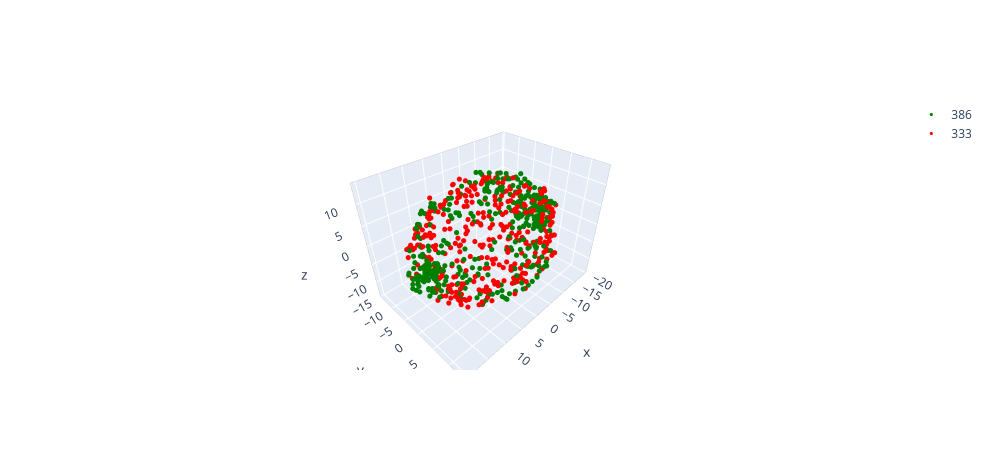

In [8]:
def _():
    pts = merged_test_data
    predicted_labels = exp_svc_50pixels_train.predict(pts)
    good_pts = pts[np.where(predicted_labels == test_labels)]
    bad_pts = pts[np.where(predicted_labels != test_labels)]
    traces = []
    traces.append(go.Scatter3d(
        x=good_pts[:, 0], y=good_pts[:, 1], z=good_pts[:, 2],
        mode='markers', marker=dict(size=3, color='green'), name=str(len(good_pts))))
    traces.append(go.Scatter3d(
        x=bad_pts[:, 0], y=bad_pts[:, 1], z=bad_pts[:, 2],
        mode='markers', marker=dict(size=3, color='red'), name=str(len(bad_pts))))
    plotly.offline.iplot(traces)
_()

Correctly (green) and incorrectly (red) classified states using the SVC over ***three*** dimensions:

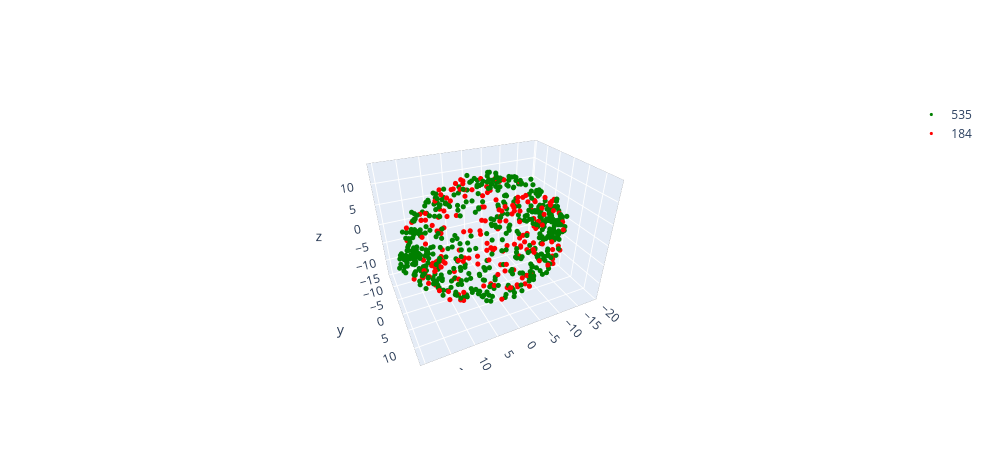

In [10]:
def _():
    pts = merged_test_data[:, :3]
    predicted_labels = exp_svc_50pixels_3dims_train.predict(pts)
    good_pts = pts[np.where(predicted_labels == test_labels)]
    bad_pts = pts[np.where(predicted_labels != test_labels)]
    traces = []
    traces.append(go.Scatter3d(
        x=good_pts[:, 0], y=good_pts[:, 1], z=good_pts[:, 2],
        mode='markers', marker=dict(size=3, color='green'), name=str(len(good_pts))))
    traces.append(go.Scatter3d(
        x=bad_pts[:, 0], y=bad_pts[:, 1], z=bad_pts[:, 2],
        mode='markers', marker=dict(size=3, color='red'), name=str(len(bad_pts))))
    plotly.offline.iplot(traces)
_()

As also shown in the above images with green and red points, training the SVC classifier over the training set does not generalise well to the test set. Interestingly, the results improve significantly (while still being pretty bad) if the classifier if trained over only three dimensions, instead of five like in the first case.

This indicates that the SVC is mostly overfitting the data, and not picking up the real pattern. This can be understood as a natural consequence of the fact that the classes do not have a clearly marked separation between them, so that there can be (and there are) points very close to the boundaries between classes.

The fact that training over three dimensions is better than over five is further evidence towards the fact that only the first three dimensions carry significant information about the state.

In [89]:
print('Train accuracy using five dimensions: {}'.format(
    np.count_nonzero(train_labels == exp_svc_50pixels_train.predict(merged_train_data)) / train_labels.shape[0]))
print('Test accuracy using five dimensions: {}'.format(
    np.count_nonzero(test_labels == exp_svc_50pixels_train.predict(merged_test_data)) / test_labels.shape[0]))

Train accuracy: 0.9916434540389972
Test accuracy: 0.5368567454798331


In [88]:
print('Train accuracy using three dimensions: {}'.format(
    np.count_nonzero(train_labels == exp_svc_50pixels_3dims_train.predict(merged_train_data[:, :3])) / train_labels.shape[0]))
print('Test accuracy using three dimensions: {}'.format(
    np.count_nonzero(test_labels == exp_svc_50pixels_3dims_train.predict(merged_test_data[:, :3])) / test_labels.shape[0]))

Train accuracy: 0.9693593314763231
Test accuracy: 0.7440890125173852


Fraction of correctly predicted labels, for each true label, for the `train` dataset (the same one used to train the classifier):

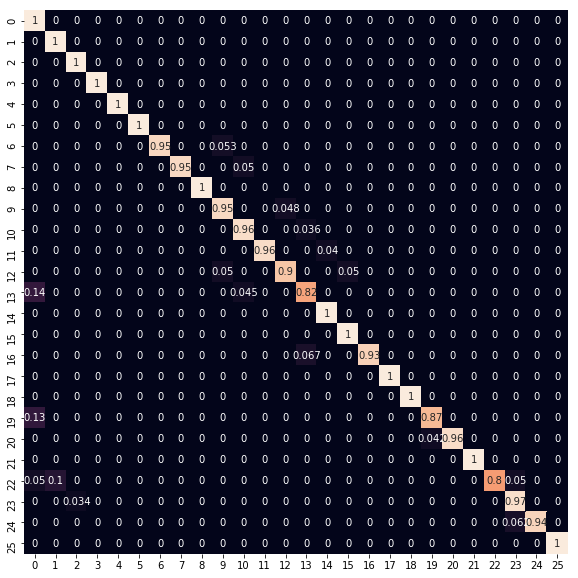

In [128]:
def _():
    svc = exp_svc_50pixels_3dims_train
    
    merged_data = merged_train_data
    labels = train_labels.astype(np.int)
    predicted_labels = svc.predict(merged_train_data[:, :3])

    predicted_features = utils.compute_accuracies_per_label(
        true_labels=labels,
        predicted_labels=predicted_labels
    )

    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.heatmap(
        data=list(predicted_features.values()), ax=ax,
        annot=True, square=True, cbar=False,
        xticklabels=predicted_features.keys(), yticklabels=predicted_features.keys()
    );

_()

Fraction of correctly predicted labels, for each true label, for the `test` dataset (*not* the same one used to train the classifier):

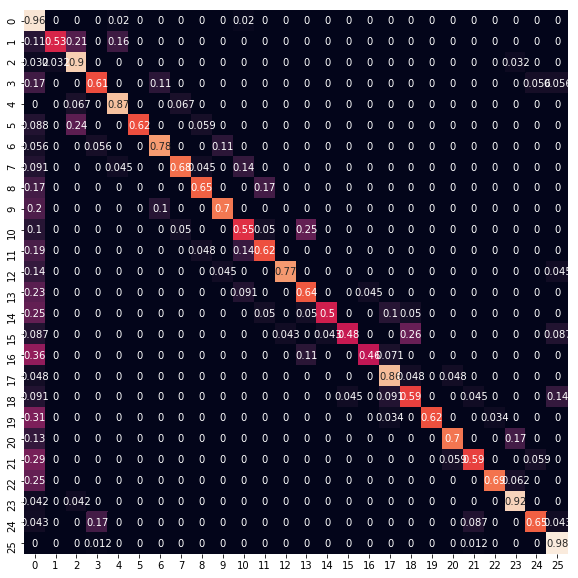

In [126]:
def _():
    svc = exp_svc_50pixels_3dims_train
    
    merged_data = merged_test_data
    labels = test_labels.astype(np.int)
    predicted_labels = svc.predict(merged_test_data[:, :3])

    predicted_features = utils.compute_accuracies_per_label(
        true_labels=labels,
        predicted_labels=predicted_labels
    )

    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.heatmap(
        data=list(predicted_features.values()), ax=ax,
        annot=True, square=True, cbar=False,
        xticklabels=predicted_features.keys(), yticklabels=predicted_features.keys()
    );

_()

## Direct regression using principal components

Because, as shown above, the classification task on classes defined on the Bloch sphere is ill-defined, we should instead treat this as a *regression* problem. Here we show how this can be done, by recovering the principal axes of the hidden Bloch sphere, and using the way images are placed in this sphere to infer the underlying state.

Use the following to load the image dataset and apply PCA on it

In [ ]:
pca = exp_pca_100pixels_full
data_dir = os.path.join('..', 'data', 'experimental', '26classes')
pixel_width = int(np.sqrt(pca.components_[0].shape[0] // 3))  # assumes NxNx3 pixels
reduced_images = data_files_utils.load_and_reduce_images_in_dir(
    data_dir=data_dir, reducer=pca, output_shape=(pixel_width, pixel_width),
    return_classes=True, monitor='progressbar'
)
merged_data, train_labels = utils.dict_of_arrays_to_labeled_array(reduced_images)

In [ ]:
# pca = exp_pca_100pixels_full
# data_dir = os.path.join('..', 'data', 'experimental', '26classes')
# pixel_width = int(np.sqrt(pca.components_[0].shape[0] // 3))  # assumes NxNx3 pixels
# reduced_images = data_files_utils.load_and_reduce_images_in_dir(
#     data_dir=data_dir, reducer=pca, output_shape=(pixel_width, pixel_width),
#     return_classes=True, monitor='progressbar'
# )
# merged_data, train_labels = utils.dict_of_arrays_to_labeled_array(reduced_images)

Use the following to load the PCA reducer, previously trained on the experimental images dataset in the same folder. We also load the images dataset to make it easy to process afterwards (takes a couple of minutes)

In [33]:
# data_dir = os.path.join('..', 'data', 'experimental', '26classes')
# with open(os.path.join(data_dir, 'trained_ipca_exp26classes_100x100pixels.pickle'), 'rb') as fp:
#     exp_pca_100pixels_full = pickle.load(fp)

exp_26classes_fulldataset = data_files_utils.ImagesDatasetToReduce(
    data_dir=os.path.join('..', 'data', 'experimental', '26classes'),
    pca=exp_pca_50pixels_train, monitor='progressbar'
)

Computing reduced representation of the images


100% (26 of 26) |########################| Elapsed Time: 0:06:20 Time:  0:06:20


In [12]:
data_dir = os.path.join('..', 'data', 'experimental', '26classes')
with open(os.path.join(data_dir, 'trained_ipca_exp26classes_100x100pixels.pickle'), 'rb') as fp:
    exp_pca_100pixels_full = pickle.load(fp)

exp_26classes_fulldataset = data_files_utils.ImagesDatasetToReduce(
    data_dir=os.path.join('..', 'data', 'experimental', '26classes'),
    pca=exp_pca_100pixels_full, monitor='progressbar'
)

/adsusers/40168729/miniconda3/envs/keras/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator IncrementalPCA from version 0.20.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.



Computing reduced representation of the images


100% (26 of 26) |########################| Elapsed Time: 0:04:07 Time:  0:04:07


Use the following the show the experimental images reduced in three dimensions:

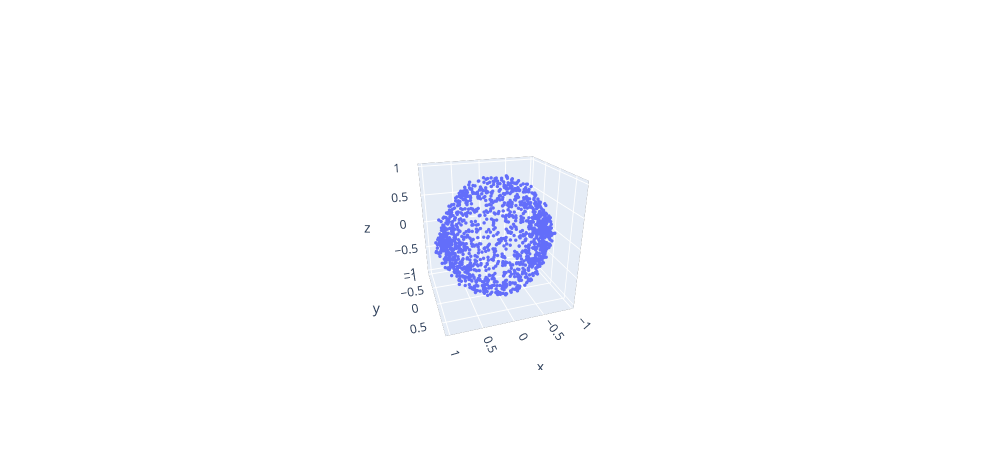

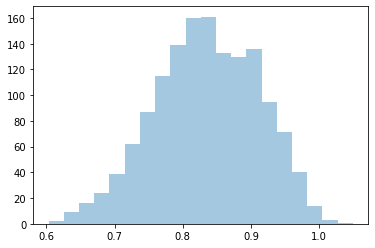

In [31]:
def _():
    pts = exp_26classes_fulldataset.merged_data[:, :3]
    maxes = np.max(np.abs(pts), axis=0)
    pts = pts / maxes
    pca = exp_26classes_fulldataset.pca

    traces = []
    traces.append(go.Scatter3d(
        # x=pts[:, 0] / maxes[0], y=pts[:, 1] / maxes[1], z=pts[:, 2] / maxes[2],
        x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
        mode='markers', marker=dict(size=2), name=str(len(pts))))
    plotly.offline.iplot(traces)
    # plot histogram of radii
    # _, ax = plt.subplots(1, 1)
    radii = scipy.linalg.norm(pts, axis=1)
    ax = sns.distplot(radii, kde=False, bins=20)
    np.savetxt(fname='./radii_PCA_regression.txt', X=radii)
_()

1.0165398598587438


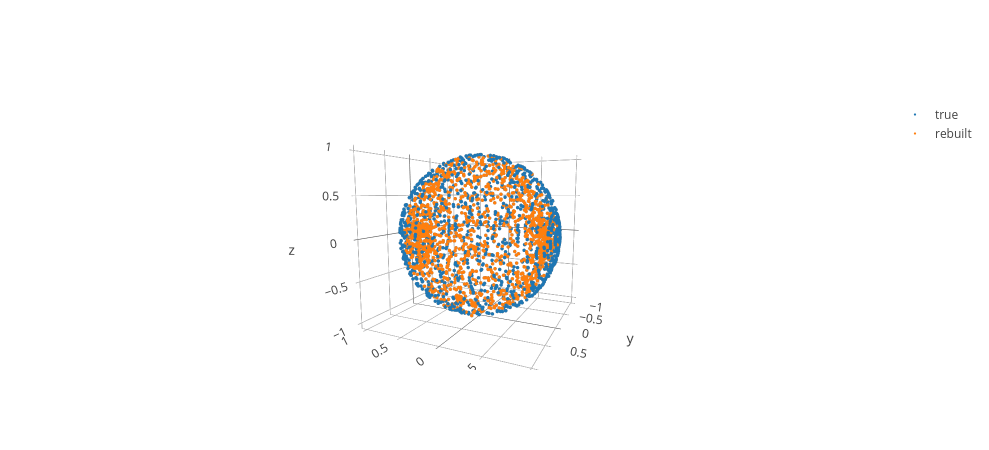

In [357]:
def filename_to_angles(fullpath):
    name = os.path.splitext(os.path.split(fullpath)[-1])[0]
    alpha_str, beta_str = name.split('_')
    degree_to_radians_factor = np.pi / 180
    alpha = degree_to_radians_factor * float(alpha_str.split('=')[1])
    beta = degree_to_radians_factor * float(beta_str.split('=')[1])
    return alpha, beta

def filename_to_xyz(fullpath):
    name = os.path.splitext(os.path.split(fullpath)[-1])[0]
    alpha_str, beta_str = name.split('_')
    degree_to_radians_factor = np.pi / 180
    alpha = degree_to_radians_factor * float(alpha_str.split('=')[1])
    beta = degree_to_radians_factor * float(beta_str.split('=')[1])
    r = 1  # we assume unit radius, also alpha=theta and beta=phi
    z = r * np.cos(alpha)
    rho = r * np.sin(alpha)
    x = rho * np.cos(beta)
    y = rho * np.sin(beta)
    return x, y, z

def rescale_vecs_axes(pts):
    """Rescale independently the three axes into the [-1, 1] range."""
    # pts = np.delete(pts, [434], axis=0)
    pts = np.array(pts)
    pts[:, 0] = 2 * pts[:, 0] / (pts[:, 0].max() - pts[:, 0].min())
    pts[:, 1] = 2 * pts[:, 1] / (pts[:, 1].max() - pts[:, 1].min())
    pts[:, 2] = 2 * pts[:, 2] / (pts[:, 2].max() - pts[:, 2].min())
    return pts

image_files = data_files_utils.ImageDataFolder(os.path.join('..', 'data', 'experimental', 'bloch_sphere_26classes_withAngles')).image_files
# num_images = 1431
# image_files = np.random.choice(np.asarray(image_files), size=num_images)
ideal_coordinates = np.asarray([filename_to_xyz(path) for path in image_files])
ideal_coordinates = ideal_coordinates[:, [2, 0, 1]]
ideal_coordinates[:, 0] = -ideal_coordinates[:, 0]


# ideal_coordinates = ideal_coordinates[:num_images, :]
rebuilt_coordinates = data_files_utils.load_and_reduce_images(image_files, reducer=pca, output_shape=(100, 100))[:, :3]
rebuilt_coordinates = rescale_vecs_axes(rebuilt_coordinates)
print(rebuilt_coordinates[:, 0].max())

traces = []
traces.append(go.Scatter3d(
    x=ideal_coordinates[:, 0], y=ideal_coordinates[:, 1], z=ideal_coordinates[:, 2],
    mode='markers', marker=dict(size=2), name='true'))
traces.append(go.Scatter3d(
    x=rebuilt_coordinates[:, 0], y=rebuilt_coordinates[:, 1], z=rebuilt_coordinates[:, 2],
    mode='markers', marker=dict(size=2), name='rebuilt'))
plotly.offline.iplot(traces)

# PCA + SVC for *15 classes* experimental dataset

Split the images in the file in two sets (*don't run if you don't know what you are doing!*)

In [265]:
# data_dir = os.path.join('..', 'data', 'experimental', '15classes')
# out_data_dir = os.path.join('..', 'data', 'experimental', '15classes_split')
# np.random.seed(0)
# data_files_utils.ImageDataFolder(data_dir).split_into_train_and_test_dirs(new_root_path=out_data_dir, train_ratio=0.5)

## PCA + SVC classification, reducing to 10 dimensions

Working on the split dataset produced above, we
1. Train PCA on the `train` dataset
2. Reduce the images in the `train` dataset and train SVC on the corresponding vectors
3. Reduce the `test` images and *test* the previously trained SVC on the corresponding vectors

This does not work particularly well. The `rbf` classifier works better than the `linear` one.

In [148]:
exp_15classes_traindataset_10dims = data_files_utils.ImagesDatasetToReduce(
    data_dir=os.path.join('..', 'data', 'experimental', '15classes_split', 'train'),
    n_components=10, images_shape=(100, 100), monitor='progressbar'
)

exp_15classes_testdataset_10dims = data_files_utils.ImagesDatasetToReduce(
    data_dir=os.path.join('..', 'data', 'experimental', '15classes_split', 'test'),
    pca=exp_15classes_traindataset_10dims.pca
)

Training PCA on given dataset


100% (15 of 15) |########################| Elapsed Time: 0:01:58 Time:  0:01:58


Computing reduced representation of the images


100% (15 of 15) |########################| Elapsed Time: 0:01:51 Time:  0:01:51


Computing reduced representation of the images


Plot the first 10 singular values computed from the experimental dataset:

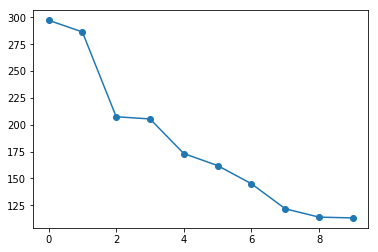

In [149]:
plt.plot(exp_15classes_testdataset_10dims.pca.singular_values_, 'o-');

Truth table, using linear SVC:

In [132]:
# sorted([utils.switch_from_cs_to_sensible_convention()[s] for s in predicted_features.keys()])
# exp_15classes_traindataset_10dims.svc.predict(exp_15classes_testdataset_10dims.merged_data)

Counter({True: 811, False: 173})


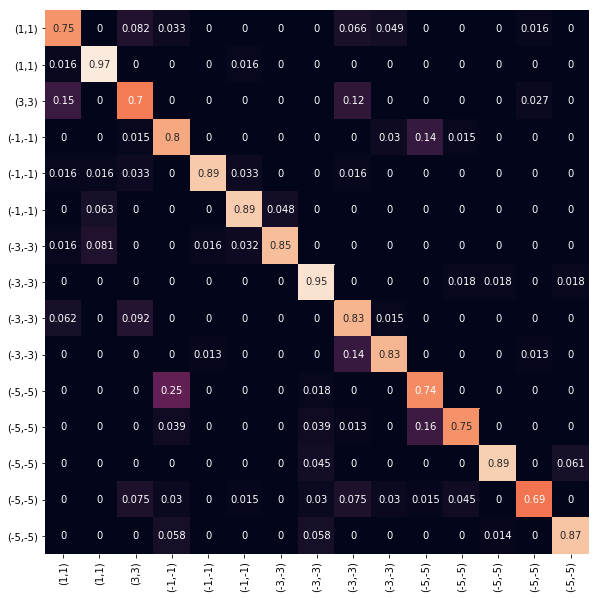

In [171]:
exp_15classes_traindataset_10dims.train_svc(kernel='linear', gamma='auto')
print(exp_15classes_testdataset_10dims.test_svc_accuracy(exp_15classes_traindataset_10dims.svc))

predicted_features = utils.compute_accuracies_per_label(
    true_labels=exp_15classes_testdataset_10dims.labels,
    predicted_labels=exp_15classes_traindataset_10dims.svc.predict(exp_15classes_testdataset_10dims.merged_data)
)
nice_labels = ['({},{})'.format(int(s[:2]), int(s[:-2])) for s in predicted_features.keys()]
_, ax = plt.subplots(1, 1, figsize=(10, 10))
g = sns.heatmap(
    data=list(predicted_features.values()), ax=ax,
    annot=True, square=True, cbar=False,
    xticklabels=nice_labels, yticklabels=nice_labels
);
g.set_xticklabels(nice_labels, rotation=90)
g.set_yticklabels(nice_labels, rotation=0);

Truth table, using RBF SVC:

Counter({True: 900, False: 84})


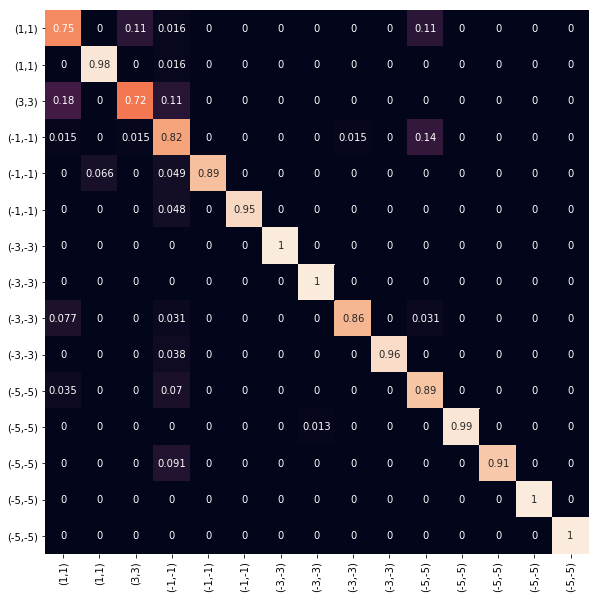

In [172]:
exp_15classes_traindataset_10dims.train_svc(kernel='rbf', gamma='auto')
print(exp_15classes_testdataset_10dims.test_svc_accuracy(exp_15classes_traindataset_10dims.svc))

predicted_features = utils.compute_accuracies_per_label(
    true_labels=exp_15classes_testdataset_10dims.labels,
    predicted_labels=exp_15classes_traindataset_10dims.svc.predict(exp_15classes_testdataset_10dims.merged_data)
)
nice_labels = ['({},{})'.format(int(s[:2]), int(s[:-2])) for s in predicted_features.keys()]
_, ax = plt.subplots(1, 1, figsize=(10, 10))
g = sns.heatmap(
    data=list(predicted_features.values()), ax=ax,
    annot=True, square=True, cbar=False,
    xticklabels=nice_labels, yticklabels=nice_labels
);
g.set_xticklabels(nice_labels, rotation=90)
g.set_yticklabels(nice_labels, rotation=0);

## Same as above, but with $40$ dimensions

Use the following to load experimental images, find the principal components on the train dataset, and then project the images in the test set on their first 40 principal components.

In [3]:
exp_15classes_traindataset_40dims = data_files_utils.ImagesDatasetToReduce(
    data_dir=os.path.join('..', 'data', 'experimental', '15classes_split', 'train'),
    n_components=40, images_shape=(100, 100), monitor='progressbar'
)

exp_15classes_testdataset_40dims = data_files_utils.ImagesDatasetToReduce(
    data_dir=os.path.join('..', 'data', 'experimental', '15classes_split', 'test'),
    pca=exp_15classes_traindataset_40dims.pca, monitor='progressbar'
)

Training PCA on given dataset


100% (15 of 15) |########################| Elapsed Time: 0:02:08 Time:  0:02:08


Computing reduced representation of the images


100% (15 of 15) |########################| Elapsed Time: 0:01:51 Time:  0:01:51


Computing reduced representation of the images


100% (15 of 15) |########################| Elapsed Time: 0:01:52 Time:  0:01:52


Now train and test and SVC classifier on the reduced data:

In [17]:
exp_15classes_traindataset_40dims.train_svc(kernel='rbf', gamma='auto')
accuracy = exp_15classes_testdataset_40dims.test_svc_accuracy(exp_15classes_traindataset_40dims.svc)
print('Accuracy: {}.\nCorrect ratio: {:.3f}'.format(accuracy, accuracy[True] / (accuracy[True] + accuracy[False])))

Accuracy: Counter({True: 928, False: 56}).
Correct ratio: 0.943


Looking at the principal components, there is no obvious separation between "meaningful" and "not meaningful" components. This is consistent with the behaviour of the singular values shown above, as there is no clear separation between the singular values. This might be because the true underlying dimension is bigger than $40$.
Note that this isn't surprising, as there are $6\times 2$ orthogonal modes in the dataset, so the underlying dimension of the full state space is $12^2$, although only a small subset of this space is actually covered by the images so the actual dimension of the dataset will be much smaller than $12^2=144$.
Still, we can expect that the first few dimensions are sufficient to distinguish rather well between the states.

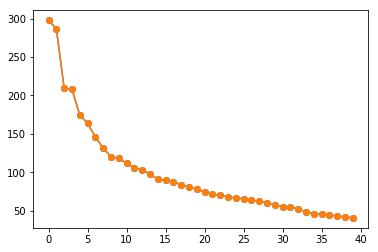

In [6]:
plt.plot(exp_15classes_traindataset_40dims.pca.singular_values_, 'o-');
plt.plot(exp_15classes_testdataset_40dims.pca.singular_values_, 'o-');

Show first 40 principal components of the experimental images:

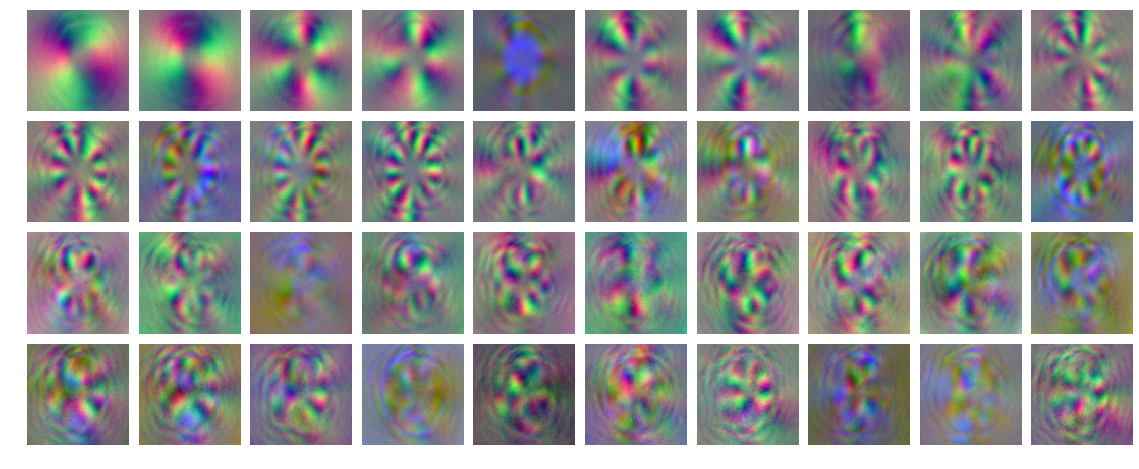

In [178]:
num_components = 40
fig, axs = plt.subplots(ncols=num_components // 4, nrows=4, figsize=(20, 8))
for idx, component in enumerate(exp_15classes_traindataset_40dims.pca.components_[:num_components]):
    col_idx = int(idx / 10)
    row_idx = idx - 10 * int(idx / 10)
    rescaled_image = utils.rescale_array_values(component.reshape((100, 100, 3)), [0, 1])
    axs[col_idx, row_idx].imshow(rescaled_image)
    axs[col_idx, row_idx].axis('off')
plt.subplots_adjust(wspace=0, hspace=.1)

Truth table for ***rbf SVM classifier***:

Accuracy: Counter({True: 928, False: 56}).
Correct ratio: 0.943


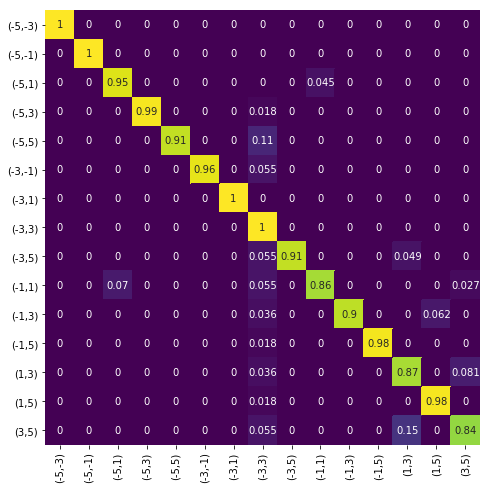

In [105]:
def _():
    exp_15classes_traindataset_40dims.train_svc(kernel='rbf', gamma='auto')
    accuracy = exp_15classes_testdataset_40dims.test_svc_accuracy(exp_15classes_traindataset_40dims.svc)
    print('Accuracy: {}.\nCorrect ratio: {:.3f}'.format(accuracy, accuracy[True] / (accuracy[True] + accuracy[False])))
    utils.print_truth_table_pd(
        pd.Series(exp_15classes_testdataset_40dims.labels, name='actual'),
        pd.Series(exp_15classes_traindataset_40dims.svc.predict(exp_15classes_testdataset_40dims.merged_data), name='predicted'),
        prettifier=lambda x: '({},{})'.format(int(x[:2]), int(x[-2:])),
        elements_sorter=lambda x: (int(x[:2]), int(x[-2:]))
    )
_()

Truth table for ***linear SVM classifier***:

Accuracy: Counter({True: 963, False: 21}).
Correct ratio: 0.979


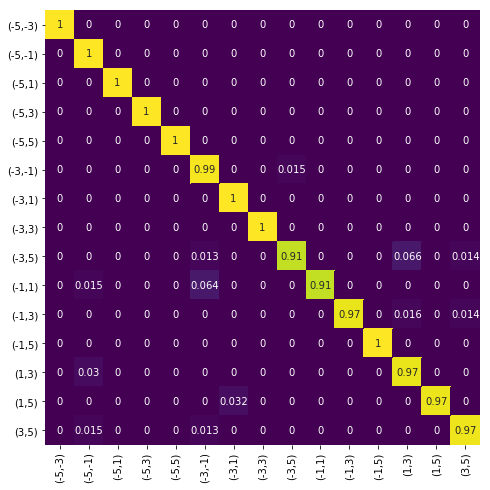

In [110]:
def _():
    exp_15classes_traindataset_40dims.train_svc(kernel='linear', gamma='auto')
    accuracy = exp_15classes_testdataset_40dims.test_svc_accuracy(exp_15classes_traindataset_40dims.svc)
    print('Accuracy: {}.\nCorrect ratio: {:.3f}'.format(accuracy, accuracy[True] / (accuracy[True] + accuracy[False])))
    fig, ax = utils.print_truth_table_pd(
        pd.Series(exp_15classes_testdataset_40dims.labels, name='actual'),
        pd.Series(exp_15classes_traindataset_40dims.svc.predict(exp_15classes_testdataset_40dims.merged_data), name='predicted'),
        prettifier=lambda x: '({},{})'.format(int(x[:2]), int(x[-2:])),
        elements_sorter=lambda x: (int(x[:2]), int(x[-2:]))
    )
    plt.savefig('coolfig.pdf')
_()

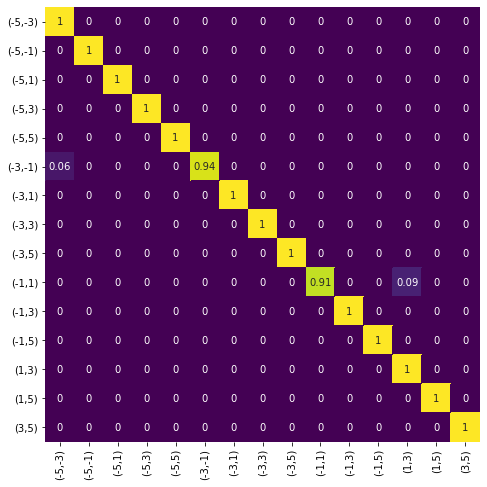

In [28]:
def _():
    labels = list(set(utils.switch_from_cs_to_sensible_convention().values()))
    labels = sorted(labels, key=lambda x: (int(x[:2]), int(x[-2:])))
    prettifier = lambda x: '({},{})'.format(int(x[:2]), int(x[-2:]))
    pretty_labels = [prettifier(label) for label in labels]
    df = pd.DataFrame(np.identity(15))
    df.columns = labels
    df.index = labels
    df.iloc[5, 0] = 0.06
    df.iloc[5, 5] = 0.94
    df.iloc[9, 9] = 0.91
    df.iloc[9, 12] = 0.09
    _, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(df, ax=ax, square=True, annot=True, cbar=False, cmap='viridis')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(pretty_labels)
    ax.set_yticklabels(pretty_labels)
    plt.savefig('accuracies15classes_CNN_Taira.pdf')
_()